<h5> Description of dataset and task

The Entertainment Software Rating Board(ESRB) ratings provide information about the contents of a game so parents and consumers can make informed choices about which game are right for the family (https://www.esrb.org/#rating-categories).

The *Video Games Rating by 'ESRB'* is a dataset composed of **1895** games with 34 of *ESRB Rating Content* along with its name and console exclusivity as features for each game. 
<p> This Notebook aims to create and experiment models capable of classifying games into their proper *ESRB Rating*. </p>


*ESRB Rating Content* (32) refers to the following:
- Alcohol Reference : Reference to and/or images of alcoholic beverages.
- Animated Blood : Discolored and/or unrealistic depictions of blood.
- Blood : Depictions of blood.
- Blood and Gore : 	Depictions of blood or the mutilation of body parts.
- Cartoon Violence : Violent actions involving cartoon-like situations and characters. May include violence where a character is unharmed after the action has been inflicted.
- Crude Humor : Depictions or dialogue involving vulgar antics, including "bathroom" humor.
- Drug Reference : 	Reference to and/or images of illegal drugs.
- Fantasy Violence : Violent actions of a fantasy nature, involving human or non-human characters in situations easily distinguishable from real life.
- Intense Violence : Graphic and realistic-looking depictions of physical conflict. May involve extreme and/or realistic blood, gore, weapons, and depictions of human injury and death.
- Language : Moderate use of profanity.
- Lyrics : References to profanity, sexuality, violence, alcohol, or drug use in music.
- Mature Humor : Depictions or dialogue involving "adult" humor, including sexual references.
- Mild Blood : 	Some blood.
- Mild Cartoon Violence : Some violent actions involving cartoon.
- Mild Fantasy Violence : Some violent actions of a fantasy nature.
- Mild Language : 	Mild to moderate use of profanity.
- Mild Lyrics : Mild References to profanity, sexuality, violence, alcohol, or drug use in music.
- Mild Suggestive Themes : 	some provocative references or materials
- Mild Violence : 	Some scenes involving aggressive conflict.
- No Descriptors : 	No content descriptors
- Nudity : 	Graphic or prolonged depictions of nudity.
- Partial Nudity : Brief and/or mild depictions of nudity.
- Sexual Content : Non-explicit depictions of sexual behavior, possibly including partial nudity.
- Sexual Themes : 	References to sex or sexuality.
- Simulated Gambling : Player can gamble without betting or wagering real cash or currency.
- Strong Language : Explicit and/or frequent use of profanity.
- Strong Sexual Content : 	Explicit and/or frequent depictions of sexual behavior, possibly including nudity.
- Suggestive Themes : 	Provocative references or materials.
- Use of Alcohol :	The consumption of alcoholic beverages.
- Use of Drugs and Alcohol : The consumption of alcoholic and drugs beverages.
- Violence : Scenes involving aggressive conflict. May contain bloodless dismemberment.

*ESRB Rating* refers to the following:
- E : Everyone
- ET : Everyone 10+
- T : teen
- M : Mature

Import revelant libraries.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

from data_loader import DataLoader

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

import optuna
from optuna.trial import TrialState

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h5>  Data Preprocessing

In [149]:
from jupyterthemes import jtplot
jtplot.style()

In [150]:
df_esrb = pd.read_csv("Video_Games_esrb_rating.csv")
df_esrb.head(5)

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [151]:
df_esrb.columns

Index(['title', 'console', 'alcohol_reference', 'animated_blood', 'blood',
       'blood_and_gore', 'cartoon_violence', 'crude_humor', 'drug_reference',
       'fantasy_violence', 'intense_violence', 'language', 'lyrics',
       'mature_humor', 'mild_blood', 'mild_cartoon_violence',
       'mild_fantasy_violence', 'mild_language', 'mild_lyrics',
       'mild_suggestive_themes', 'mild_violence', 'no_descriptors', 'nudity',
       'partial_nudity', 'sexual_content', 'sexual_themes',
       'simulated_gambling', 'strong_janguage', 'strong_sexual_content',
       'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol',
       'violence', 'esrb_rating'],
      dtype='object')

`strong_janguage` is a clear typo of `strong_language` so we replace that.

In [152]:
df_esrb = df_esrb.rename(columns={"strong_janguage" : "strong_language"})

Let's display the general `info` of the dataset

In [153]:
df_esrb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     1895 non-null   object
 1   console                   1895 non-null   int64 
 2   alcohol_reference         1895 non-null   int64 
 3   animated_blood            1895 non-null   int64 
 4   blood                     1895 non-null   int64 
 5   blood_and_gore            1895 non-null   int64 
 6   cartoon_violence          1895 non-null   int64 
 7   crude_humor               1895 non-null   int64 
 8   drug_reference            1895 non-null   int64 
 9   fantasy_violence          1895 non-null   int64 
 10  intense_violence          1895 non-null   int64 
 11  language                  1895 non-null   int64 
 12  lyrics                    1895 non-null   int64 
 13  mature_humor              1895 non-null   int64 
 14  mild_blood              

Since theres no `null` values in the dataset, we can proceed

In [154]:
df_no_desriptors = df_esrb[df_esrb['no_descriptors'] == 1].sum(axis=1) 
df_no_desriptors.shape[0]

322

Since `no_descriptors` means that none of the _ESRB Content_ is found in the game, we need to check fix games that might contradict that.

In [155]:
(df_no_desriptors>1).sum()
# print(df_no_desriptors)

205

In [156]:
idx = df_no_desriptors[df_no_desriptors>1].index
# df_esrb.iloc[idx].loc['no_descriptors'] = 0

df_esrb.loc[idx,'no_descriptors'] = 0

df_esrb.iloc[idx]['no_descriptors']

0       0
5       0
27      0
30      0
31      0
       ..
1867    0
1872    0
1875    0
1877    0
1894    0
Name: no_descriptors, Length: 205, dtype: int64

Seems like there are 205 entries have the `no_descriptors` flagged wrong.

<h5> Exploratory data analysis

Which _ESRB Rating_ is most prominent?

<BarContainer object of 4 artists>

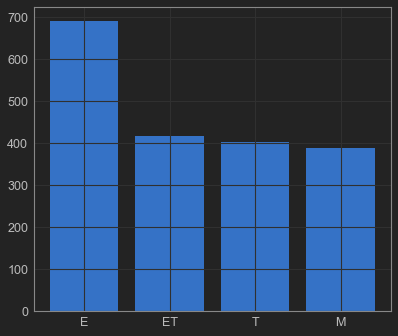

In [157]:
ratings = ["E" , "ET" , "T", "M"]

counts = df_esrb['esrb_rating'].value_counts()

plt.bar(ratings, counts)

([<matplotlib.patches.Wedge at 0x259961c9820>,
 [Text(0.4571073038439642, 1.000526317880995, 'E'),
  Text(-1.0846159132817186, 0.18332572284342297, 'ET'),
  Text(-0.40849519606388207, -1.021338178466237, 'T'),
  Text(0.8812655227327117, -0.6583092574486862, 'M')],
 [Text(0.24933125664216227, 0.5457416279350882, '36.36'),
  Text(-0.5916086799718464, 0.09999584882368524, '21.95'),
  Text(-0.2228155614893902, -0.5570935518906747, '21.27'),
  Text(0.48069028512693357, -0.3590777767901924, '20.42')])

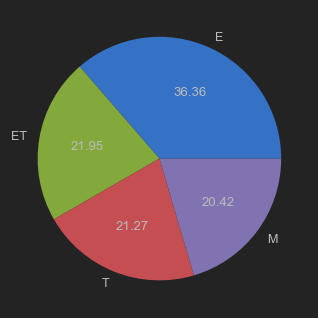

In [158]:
plt.pie(counts, labels= ratings, autopct='%.2f')

The _ESRB Rating_ **T** appears to be the most prominent rating.

Next, lets find the most prominent `ESRB Rating Content`

<AxesSubplot:>

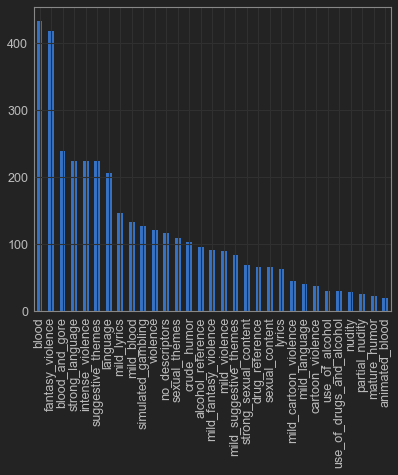

In [159]:
df_dropped = df_esrb.drop(['title','console','esrb_rating'], axis = 1)
df_count_content = df_dropped.sum(axis=0)
df_count_content.sort_values(axis=0, ascending=False, inplace=True)
df_count_content.plot.bar(x="Content", y="Count", )

We can visibly see that the _ESRB Content_ **blood** is the most prominent while **fantasy_violence** comes close in second.

Let us check the correlelations of each _ESRB Content_

In [160]:
df_esrb.columns

Index(['title', 'console', 'alcohol_reference', 'animated_blood', 'blood',
       'blood_and_gore', 'cartoon_violence', 'crude_humor', 'drug_reference',
       'fantasy_violence', 'intense_violence', 'language', 'lyrics',
       'mature_humor', 'mild_blood', 'mild_cartoon_violence',
       'mild_fantasy_violence', 'mild_language', 'mild_lyrics',
       'mild_suggestive_themes', 'mild_violence', 'no_descriptors', 'nudity',
       'partial_nudity', 'sexual_content', 'sexual_themes',
       'simulated_gambling', 'strong_language', 'strong_sexual_content',
       'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol',
       'violence', 'esrb_rating'],
      dtype='object')

In [161]:
correlation = df_dropped.corr()
correlation.style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,lyrics,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_lyrics,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
alcohol_reference,1.00,0.00,-0.08,-0.04,0.05,-0.00,0.01,-0.08,0.15,-0.03,0.08,0.11,0.02,0.12,-0.04,0.03,0.01,0.22,0.10,-0.06,0.03,-0.01,-0.04,-0.03,-0.00,-0.08,0.01,-0.00,0.16,-0.03,-0.04
animated_blood,0.00,1.00,-0.05,-0.04,-0.01,-0.00,0.15,-0.03,0.09,0.05,-0.02,-0.01,0.03,-0.02,-0.02,-0.01,-0.03,0.06,-0.02,-0.03,-0.01,-0.01,-0.02,-0.02,-0.03,-0.02,-0.02,-0.04,0.07,0.03,0.02
blood,-0.08,-0.05,1.00,-0.21,-0.07,-0.08,-0.04,-0.17,0.09,0.03,0.06,0.12,-0.13,-0.07,-0.12,-0.08,-0.01,-0.00,-0.08,-0.14,-0.02,0.05,0.08,0.07,0.11,0.29,-0.04,0.09,-0.04,-0.02,0.01
blood_and_gore,-0.04,-0.04,-0.21,1.00,-0.04,-0.03,0.12,-0.17,0.29,0.10,0.05,-0.03,-0.07,-0.06,-0.08,-0.06,-0.09,-0.04,-0.05,-0.10,0.12,-0.00,0.14,0.12,0.01,0.22,0.34,-0.03,-0.01,0.05,0.06
cartoon_violence,0.05,-0.01,-0.07,-0.04,1.00,-0.02,0.01,-0.08,-0.05,-0.05,0.04,-0.02,-0.04,0.00,-0.01,-0.02,0.00,0.08,0.02,-0.04,-0.02,-0.02,-0.03,0.03,-0.02,-0.05,-0.03,0.01,0.04,0.01,-0.04
crude_humor,-0.00,-0.00,-0.08,-0.03,-0.02,1.00,-0.05,-0.08,0.09,-0.06,0.03,0.02,-0.06,0.10,-0.02,0.01,-0.06,0.08,-0.03,-0.06,0.01,0.01,-0.03,-0.03,0.32,-0.07,0.02,-0.03,-0.01,-0.03,-0.01
drug_reference,0.01,0.15,-0.04,0.12,0.01,-0.05,1.00,-0.10,0.02,0.17,0.05,0.06,0.14,-0.01,-0.03,-0.03,0.01,0.02,0.01,-0.05,0.02,0.05,0.03,0.09,0.06,0.16,0.07,0.04,-0.02,-0.02,-0.00
fantasy_violence,-0.08,-0.03,-0.17,-0.17,-0.08,-0.08,-0.10,1.00,-0.17,-0.00,-0.03,0.06,0.23,-0.07,-0.11,-0.08,0.10,0.03,-0.01,-0.14,-0.01,-0.05,-0.04,-0.04,-0.04,-0.07,-0.05,0.08,0.00,0.00,-0.09
intense_violence,0.15,0.09,0.09,0.29,-0.05,0.09,0.02,-0.17,1.00,-0.11,0.07,0.05,-0.06,0.09,-0.07,-0.05,-0.11,0.17,0.01,-0.09,0.09,-0.04,0.00,0.02,0.01,0.10,0.39,-0.01,0.06,0.01,-0.01
language,-0.03,0.05,0.03,0.10,-0.05,-0.06,0.17,-0.00,-0.11,1.00,-0.04,-0.01,0.04,-0.05,-0.05,-0.02,-0.10,-0.08,-0.01,-0.09,0.08,0.02,-0.03,0.09,0.04,0.02,-0.01,0.08,-0.00,0.02,-0.02


It seems that generally the correlation between each *ESRB Content* is very weak with the strongest correlation of *0.39* between .

<h5> Model Training

Since the dataset already provided a separate test dataset, we wont be needing to split the training dataset. We will only need to create a validation dataset

In [162]:
label_encoder = preprocessing.LabelEncoder()

In [163]:
y = label_encoder.fit_transform(df_esrb[['esrb_rating']].values.ravel())
print(y.shape)
print(df_dropped.shape)

(1895,)
(1895, 31)


In [164]:
print(y)

[0 1 2 ... 0 3 0]


In [165]:
X = df_dropped.values

In [166]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

In [167]:
df_test = pd.read_csv("test_esrb.csv")
X_test = df_test.drop(['title','console','esrb_rating'], axis = 1).values
y_test = label_encoder.fit_transform(df_test[['esrb_rating']].values.ravel())
X_test.shape

(500, 31)

Convert pandas to tensors

In [168]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [169]:
y_train

tensor([2., 3., 1.,  ..., 2., 0., 1.])

In [170]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

<h5> Neural Network

In [171]:
# 31 -> 4
network = nn.Sequential(
    nn.Linear(31,12),
    nn.ELU(inplace=True),
    nn.Linear(12,6),
    nn.ELU(inplace=True),
    nn.Linear(6,4),
    nn.LogSoftmax(dim = 0)
)
network

Sequential(
  (0): Linear(in_features=31, out_features=12, bias=True)
  (1): ELU(alpha=1.0, inplace=True)
  (2): Linear(in_features=12, out_features=6, bias=True)
  (3): ELU(alpha=1.0, inplace=True)
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): LogSoftmax(dim=0)
)

In [172]:
data_loader = DataLoader(X_train,y_train,48)

In [173]:
loss_fn = nn.CrossEntropyLoss()

![epochs.png](epochs.png)

We trained the model with an epoch of 1500 to see what number of epochs is good for efficiency and accuracy. About 200 is where the "elbow" is seen but we decided around 350 to chase for a slight improvement in accuracy.

In [174]:
def objective(trial):
    e = 0
    max_epochs = 350
    is_converged = False
    previous_loss = 0
    losses = []

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=False)
    optimizer = getattr(optim, optimizer_name)(network.parameters(), lr=lr)

    while e < max_epochs and is_converged is not True:
    
        current_epoch_loss = 0
        
        X_batch, y_batch = data_loader.get_batch()
        
        # For each batch
        for X, y in zip(X_batch, y_batch):
            X = torch.Tensor(X)
            y = torch.Tensor(y).to(torch.long)
            
            optimizer.zero_grad()
            
            s = network.forward(X)
            
            loss = loss_fn(s,y)
            
            loss.backward()
            
            optimizer.step()
            
            current_epoch_loss += loss.item()
        
        average_loss = current_epoch_loss / len(X_batch)
        losses.append(average_loss)
        
        # Display the average loss per epoch
        # print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
        
        if abs(previous_loss - loss) < 0.0000005:
            is_converged = True
        else:
            previous_loss = loss
            e += 1
    # get accu
    network.eval()

    with torch.no_grad():
        output = network.forward(X_val)
        pred = output.argmax(dim=1, keepdim=True)
        # num_correct = torch.sum(pred == y_val)
    
    accuracy = accuracy_score(pred,y_val)*100.0
    trial.report(accuracy, e)

    return accuracy


        

    

In [175]:
# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=100)

# print("  Number of finished trials: ", len(study.trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [176]:
e = 0
max_epochs = 350
is_converged = False
previous_loss = 0
losses = []

lr = 0.009992566127730968
optimizer = optim.RMSprop(network.parameters(), lr=lr)

while e < max_epochs and is_converged is not True:

    current_epoch_loss = 0
    
    X_batch, y_batch = data_loader.get_batch()
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)
        
        optimizer.zero_grad()
        
        s = network.forward(X)
        
        loss = loss_fn(s,y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.0000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 0.605768
Epoch: 2 	Loss: 0.398001
Epoch: 3 	Loss: 0.360256
Epoch: 4 	Loss: 0.359608
Epoch: 5 	Loss: 0.349721
Epoch: 6 	Loss: 0.346319
Epoch: 7 	Loss: 0.343094
Epoch: 8 	Loss: 0.331791
Epoch: 9 	Loss: 0.332951
Epoch: 10 	Loss: 0.327885
Epoch: 11 	Loss: 0.327123
Epoch: 12 	Loss: 0.324949
Epoch: 13 	Loss: 0.318631
Epoch: 14 	Loss: 0.322886
Epoch: 15 	Loss: 0.315779
Epoch: 16 	Loss: 0.319534
Epoch: 17 	Loss: 0.311646
Epoch: 18 	Loss: 0.309105
Epoch: 19 	Loss: 0.310458
Epoch: 20 	Loss: 0.307961
Epoch: 21 	Loss: 0.304941
Epoch: 22 	Loss: 0.303895
Epoch: 23 	Loss: 0.300659
Epoch: 24 	Loss: 0.304992
Epoch: 25 	Loss: 0.299247
Epoch: 26 	Loss: 0.296178
Epoch: 27 	Loss: 0.308986
Epoch: 28 	Loss: 0.298072
Epoch: 29 	Loss: 0.285030
Epoch: 30 	Loss: 0.299923
Epoch: 31 	Loss: 0.292704
Epoch: 32 	Loss: 0.290753
Epoch: 33 	Loss: 0.283426
Epoch: 34 	Loss: 0.284587
Epoch: 35 	Loss: 0.290405
Epoch: 36 	Loss: 0.281755
Epoch: 37 	Loss: 0.288897
Epoch: 38 	Loss: 0.280625
Epoch: 39 	Loss: 0.27

Using optuna to optimize the hyperparameters (learning rate and optimizer), it came to a conclusion that Using RMSprop with a learning rate of 0.009992566127730968 resulted in the best validation accuracy, 85.4881266490765%.

In [ ]:
# study.best_trial

<font size="1"> FrozenTrial(number=1, values=[85.4881266490765], datetime_start=datetime.datetime(2022, 6, 30, 20, 25, 36, 105827), datetime_complete=datetime.datetime(2022, 6, 30, 20, 25, 47, 442350), params={'optimizer': 'RMSprop', 'lr': 0.009992566127730968}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'lr': UniformDistribution(high=0.01, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={350: 85.4881266490765}, trial_id=1, state=TrialState.COMPLETE, value=None)

In [ ]:
def test_trial(trial):
    e = 0
    max_epochs = 350
    is_converged = False
    previous_loss = 0
    losses = []

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=False)
    optimizer = getattr(optim, optimizer_name)(network.parameters(), lr=lr)

    while e < max_epochs and is_converged is not True:
    
        current_epoch_loss = 0
        
        X_batch, y_batch = data_loader.get_batch()
        
        # For each batch
        for X, y in zip(X_batch, y_batch):
            X = torch.Tensor(X)
            y = torch.Tensor(y).to(torch.long)
            
            optimizer.zero_grad()
            
            s = network.forward(X)
            
            loss = loss_fn(s,y)
            
            loss.backward()
            
            optimizer.step()
            
            current_epoch_loss += loss.item()
        
        average_loss = current_epoch_loss / len(X_batch)
        losses.append(average_loss)
        
        # Display the average loss per epoch
        # print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
        
        if abs(previous_loss - loss) < 0.0000005:
            is_converged = True
        else:
            previous_loss = loss
            e += 1
    # get accu
    network.eval()

    with torch.no_grad():
        output = network.forward(X_test)
        pred = output.argmax(dim=1, keepdim=True)
        # num_correct = torch.sum(pred == y_val)
    
    accuracy = accuracy_score(pred,y_test)*100.0
    trial.report(accuracy, e)

    return accuracy, confusion_matrix(pred,y_test), classification_report(pred,y_test,target_names=label_mapping.keys(),digits=4)

In [ ]:
study.best_trial

In [ ]:
accuracy , confusion_mat, classification_rep = test_trial(study.best_trial)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels = label_mapping)


In [ ]:
disp.plot()
plt.show()
print(classification_rep)
print("The accuracy of the neural network model is : ",accuracy,"%")

The model struggled in predicting some of the "T" rated games as "M". 

<h5> Decision Tree 

In [ ]:

dtc = DecisionTreeClassifier(random_state=42)

In [ ]:
dtc.fit(X_train, y_train)
predictions_train = dtc.predict(X_train)

In [ ]:

def compute_accuracy(predictions, actual):
    # write code here
    return accuracy_score(actual, predictions) * 100

In [ ]:
print("Training accuracy: ", compute_accuracy(y_train, predictions_train),"%")

In [ ]:
predictions = dtc.predict(X_test)
print("Testing accuracy: ", compute_accuracy(y_test, predictions),"%")

<h5> Model Selection and hyperparameter tuning

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training data label counts:")
print(np.array([unique, counts]))

In [ ]:
ratings = np.array(unique)

In [ ]:
dtc = DecisionTreeClassifier()

In [ ]:
hyperparameters = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [ 5, 10, 20, 30],
        'min_samples_split': [2, 4, 6, 10, 15, 20],
        'max_leaf_nodes': [3, 5, 10, 20, 50, 100],
    }
]

Create  `RandomizedSearchCV` object

In [ ]:
rsc_esrb = RandomizedSearchCV(dtc, n_iter=50, param_distributions=hyperparameters,cv=5,random_state=42)

In [ ]:
rsc_esrb.fit(X_train, y_train)

Get the best parameters found from hyperparameter search

In [ ]:
pd.set_option('display.max_colwidth', None)

rsc_results = pd.DataFrame(rsc_esrb.cv_results_)
rsc_results

In [ ]:
rsc_esrb.best_params_

Get the  best estimator index to in order to get the entry of the best performing model.

In [ ]:
best_index = rsc_esrb.best_index_
best_index

In [ ]:
rsc_results.loc[best_index]

Get the best estimator

In [ ]:
rsc_esrb.best_estimator_

In [ ]:
dtc = rsc_esrb.best_estimator_
dtc.fit(X_train,y_train)

In [ ]:
predictions = dtc.predict(X_test)
print("Test accuracy is : ", compute_accuracy(predictions, y_test), "%")

In [ ]:
print(classification_report(y_test, predictions,target_names=label_mapping.keys(),digits=4))


In [ ]:
cm = confusion_matrix(y_test, predictions, labels=ratings)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax)

<h5> Insights and conclusion